In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지
from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화
from keras.models import Sequential

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
image_size=48

In [5]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("../jupyter/input/emotion-project-2/train/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("../jupyter/input/emotion-project-2/train/"+img)))
    for i in path:
        image = cv2.imread("../jupyter/input/emotion-project-2/train/"+img+'/'+i)
        image = cv2.resize(image, (image_size,image_size))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['neutral', 'fear', 'happy', 'sad', 'angry', 'surprise']


In [6]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [7]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(50890, 48, 48, 3) (12723, 48, 48, 3)


In [8]:
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)
datagen.fit(xtrain)

In [9]:
#dense relu문 추가, dropout 0.2로 변경

model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x=Flatten()(model.output)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
output=Dense(6,activation='softmax')(x) # because we have to predict the AUC
model=Model(model.input,output)

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [10]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
               epochs=70,
               validation_data=(xtest, ytest))

Epoch 1/70
1591/1591 [==============================] - 60s 34ms/step - loss: 1.4524 - accuracy: 0.4095 - val_loss: 1.0554 - val_accuracy: 0.5965
Epoch 2/70
1591/1591 [==============================] - 48s 30ms/step - loss: 1.0664 - accuracy: 0.5928 - val_loss: 0.9643 - val_accuracy: 0.6413
Epoch 3/70
1591/1591 [==============================] - 54s 34ms/step - loss: 0.9421 - accuracy: 0.6498 - val_loss: 0.8991 - val_accuracy: 0.6644
Epoch 4/70
1591/1591 [==============================] - 49s 31ms/step - loss: 0.8611 - accuracy: 0.6825 - val_loss: 0.8408 - val_accuracy: 0.6888
Epoch 5/70
1591/1591 [==============================] - 49s 30ms/step - loss: 0.7839 - accuracy: 0.7118 - val_loss: 0.8393 - val_accuracy: 0.6918
Epoch 6/70
1591/1591 [==============================] - 49s 31ms/step - loss: 0.7076 - accuracy: 0.7416 - val_loss: 0.8046 - val_accuracy: 0.7085
Epoch 7/70
1591/1591 [==============================] - 49s 31ms/step - loss: 0.6414 - accuracy: 0.7692 - val_loss: 0.7431 -

1591/1591 [==============================] - 318s 200ms/step - loss: 0.0777 - accuracy: 0.9732 - val_loss: 0.6506 - val_accuracy: 0.8804
Epoch 57/70
1591/1591 [==============================] - 327s 206ms/step - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.6528 - val_accuracy: 0.8835
Epoch 58/70
1591/1591 [==============================] - 334s 210ms/step - loss: 0.0719 - accuracy: 0.9741 - val_loss: 0.6216 - val_accuracy: 0.8812
Epoch 59/70
1591/1591 [==============================] - 393s 247ms/step - loss: 0.0756 - accuracy: 0.9738 - val_loss: 0.6864 - val_accuracy: 0.8754
Epoch 60/70
1591/1591 [==============================] - 377s 237ms/step - loss: 0.0733 - accuracy: 0.9741 - val_loss: 0.6444 - val_accuracy: 0.8888
Epoch 61/70
1591/1591 [==============================] - 394s 247ms/step - loss: 0.0710 - accuracy: 0.9746 - val_loss: 0.6880 - val_accuracy: 0.8671
Epoch 62/70
1591/1591 [==============================] - 375s 236ms/step - loss: 0.0692 - accuracy: 0.9759 - val_loss:

In [11]:
model.evaluate(xtest, ytest, batch_size = 32)

398/398 [==============================] - 26s 65ms/step - loss: 0.7063 - accuracy: 0.8902


[0.7063219547271729, 0.890198826789856]

In [12]:
model.evaluate(xtrain, ytrain, batch_size = 32)

1591/1591 [==============================] - 105s 66ms/step - loss: 0.0366 - accuracy: 0.9864


[0.03659828379750252, 0.9863823652267456]

In [13]:
model.save('0530_adam_f32.h5')

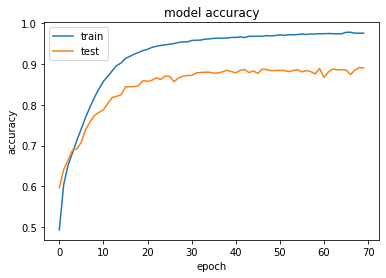

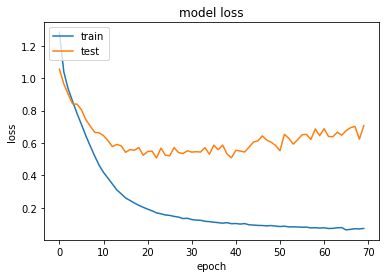

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
plt.savefig('save.png')

<Figure size 432x288 with 0 Axes>

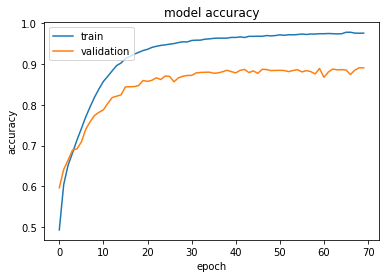

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()
plt.savefig('save2.png')